In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import yaml
import h5py
import numpy as np

import luxeics

In [3]:
input_filename = 'pencil_beam'
# input_filename = 'small_beam'
# input_filename = 'large_beam'
# input_filename = 'weird_beam'

with open( input_filename + '.yml', 'r' ) as stream:
    input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

print (input_dict)

{'control': {'sampling': 'rejection', 'xsection': 'Full', 'beam': {'sample_electrons': '1e8', 'sample_batch_size': '1e7'}, 'laser': {'sigma_rescale': True, 'sigma_crit': 500.0}, 'detector': {'a0_freq_correction': False}}, 'beam': {'gamma': 32289.62818003914, 'energyspread': '1e-3', 'emittanceX': 0.0, 'emittanceY': 0.0, 'sigmaX': 2.0, 'sigmaY': 2.0, 'sigmaL': 20.0, 'beam_charge': '100e-12', 'beam_focus_z': 0, 'baseline': '7.5e6'}, 'laser': {'a0': 0.1, 'omega0': 4.1, 'Tpulse': 100.0, 'pulse': 'cos2', 'w0': 25.0, 'polangle': 0.0, 'poldegree': 1.0}, 'detector': {'pdim': 3, 'omega': ['5.0e9', '9.2e9'], 'theta': [0, '15e-6'], 'phi': [0.0, 6.283185307179586]}}


In [17]:
SIM = luxeics.ICSSimulation( input_filename )
# SIM.run()
SIM.read()

print (dir(SIM))

 >> rescale pulse duration: 855.50 -> 500.00: sigma_rescalefactor = 1.71
['Compton_Spectrum', 'K_photon', 'MC_sampling_one_batch', 'P_electron', 'Stokes_photon', 'Tpulse', 'W_electron', 'W_photon', 'X_electron', 'X_photon', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'a0', 'a0_freq_correction', 'beam_charge', 'beam_focus_z', 'beam_length', 'beam_size_X', 'beam_size_Y', 'define_batches', 'define_detector', 'emittance_X', 'emittance_Y', 'energyspread', 'filename', 'gamma0', 'generate_electron_beam', 'input_dict', 'omega0', 'polangle', 'poldegree', 'pulse', 'read', 'read_beam_parameters', 'read_laser_parameters', 'run', 'sigma', 'sigma_crit', 'sigma_rescale', 'sigma_rescalefactor', 'total_energ

In [20]:
SIM.K_photon.shape

K0,K1,K2,K3       = SIM.K_photon
X0,X1,X2,X3       = SIM.X_photon
W                 = SIM.W_photon
Stokes1,_,Stokes3 = SIM.Stokes_photon

P0,P1,P2,P3       = SIM.P_electron

In [6]:
# # input_filename = 'small_beam_full'

# with h5py.File(input_filename + '.h5' ,'r') as ff:
# #     omega      = ff['final-state/spectrum/omega'][:]/1e9
# #     theta      = ff['final-state/spectrum/theta'][:]*1e6
# #     spectrum   = ff['final-state/spectrum/spectrum'][:]

#     K0,K1,K2,K3       = ff['final-state/photon/momentum'][:]
#     X0,X1,X2,X3       = ff['final-state/photon/position'][:]
#     W                 = ff['final-state/photon/weight'  ][:]
#     Stokes1,_,Stokes3 = ff['final-state/photon/Stokes'  ][:]

#     P0,P1,P2,P3  = ff['final-state/electron/momentum'][:]
# #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
# #     We            = ff['final-state/photon/weight'  ][:]


In [21]:
with open( input_filename + '.yml', 'r' ) as stream:
    input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
    
#     mode             = input_dict['control']['mode']
    
    
    beam_charge      = float( input_dict['beam']['beam_charge'])
    number_electrons = int( beam_charge / 1.60217653e-19)

    sampling         = input_dict['control']['sampling']
#     sampling = mode
    
    w0               = float(input_dict['laser']['w0'])


In [22]:
print (f'beam charge                              : {beam_charge*1e12:.24} pC')
print (f'number of beam electrons                 : {number_electrons:.4e}')
print ('-'*42)
print (f'{sampling} sampling:')
print (f'max  single photon weight                : {amax(W):.4g}')
print (f'mean single photon weight                : {mean(W):.4g}')
print (f'total photon weight                      : {sum(W):.4g}')
print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
print (f'total macro photon number                : {len(W)}')
print ('-'*42)


beam charge                              : 100.0 pC
number of beam electrons                 : 6.2415e+08
------------------------------------------
rejection sampling:
max  single photon weight                : 3.443
mean single photon weight                : 3.418
total photon weight                      : 1.527e+06
total photon weight per incident electron: 0.002446
total macro photon number                : 446626
------------------------------------------


In [9]:
# beam charge                              : 100.0 pC
# number of beam electrons                 : 6.2415e+08
# ------------------------------------------
# mode: full
# rejection sampling:
# max  single photon weight                : 17.07
# mean single photon weight                : 17.07
# total photon weight                      : 2.459e+06
# total photon weight per incident electron: 0.00394
# total macro photon number                : 144065
# ------------------------------------------
# mode: simple
# rejection sampling:
# max  single photon weight                : 7.483
# mean single photon weight                : 7.483
# total photon weight                      : 2.475e+06
# total photon weight per incident electron: 0.003965
# total macro photon number                : 330724
# ------------------------------------------

In [10]:
# figure(figsize=(10,6))
# pcolormesh(omega.ravel(),theta.ravel(),spectrum.T,rasterized=True,cmap=cm.magma)
# xlim(6,9)
# ylim(0,15)
# colorbar(label='spectrum')

# xlabel(r'$\omega$ (GeV)')
# ylabel(r'$\theta$ ($\mu$rad)')

# savefig('spectrum.pdf')

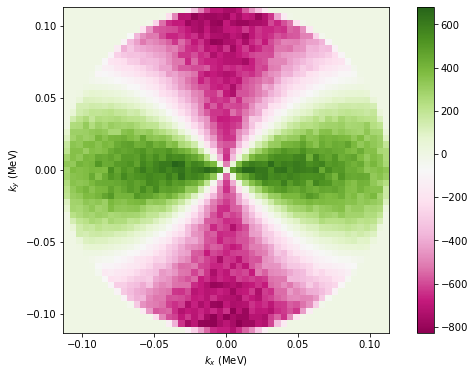

In [23]:
figure(figsize=(10,6))

subplot(111,aspect=1)
hist2d(K1/1e6,K2/1e6,bins=(51,51),weights=W*Stokes3,rasterized=True,cmap=cm.PiYG);
colorbar()

xlabel(r'$k_x$ (MeV)')
ylabel(r'$k_y$ (MeV)')


savefig(f'photon_transverse_momentum_Stokes3_{input_filename}.pdf')


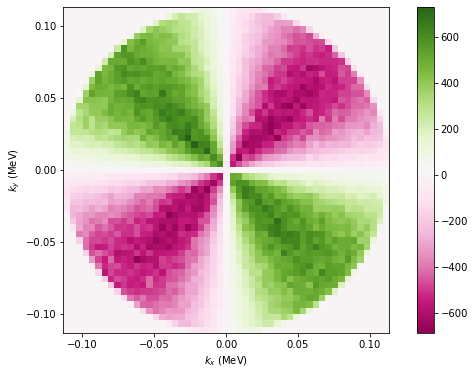

In [12]:
figure(figsize=(10,6))

subplot(111,aspect=1)
hist2d(K1/1e6,K2/1e6,bins=(51,51),weights=W*Stokes1,rasterized=True,cmap=cm.PiYG);
colorbar()

xlabel(r'$k_x$ (MeV)')
ylabel(r'$k_y$ (MeV)')


savefig(f'photon_transverse_momentum_Stokes1_{input_filename}.pdf')


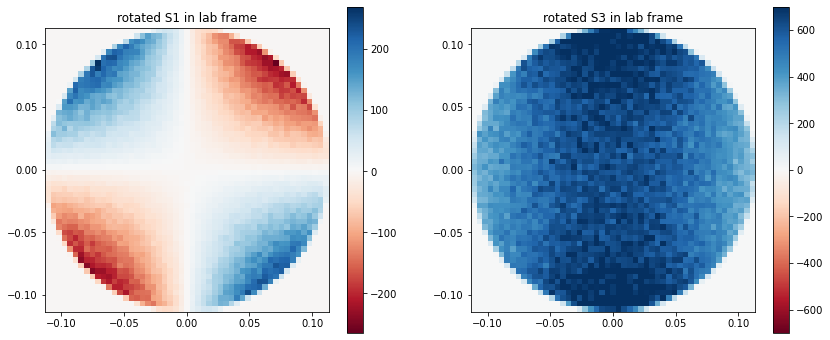

In [13]:
phi =  arctan2(K2,K1)

# rotated Stokes parameters
Stokes_rot3 = cos(2*phi) * Stokes3 - sin(2*phi) * Stokes1
Stokes_rot1 = sin(2*phi) * Stokes3 + cos(2*phi) * Stokes1


fig, ax = subplots(ncols=2,nrows=1,figsize=(14,6))

for axj in ax:
    axj.set_aspect(1)
    
H1=histogram2d(K1/1e6,K2/1e6,bins=(51,52),weights=W*Stokes_rot1);
p=ax[0].pcolormesh(H1[1],H1[2],H1[0].T,rasterized=True,cmap=cm.RdBu)
plt.colorbar(p,ax=ax[0])
ax[0].set_title('rotated S1 in lab frame')

H2=histogram2d(K1/1e6,K2/1e6,bins=(51,52),weights=W*Stokes_rot3);
p=ax[1].pcolormesh(H2[1],H2[2],H2[0].T,rasterized=True,cmap=cm.RdBu, vmin=-700,vmax=700)
plt.colorbar(p,ax=ax[1])
ax[1].set_title('rotated S3 in lab frame')

savefig('StokesParameters_rotated_labframe_{input_filename}.pdf')

/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_88697/3633346578.py:23: RuntimeWarning: invalid value encountered in divide
  p=ax[0].pcolormesh( xedge, yedge, (values_w_s / values_w).T ,rasterized=True,cmap=cm.plasma);
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_88697/3633346578.py:27: RuntimeWarning: invalid value encountered in divide
  tilt_angle_in_lab_rot = values_w_tilt / values_w
/var/folders/p4/q502wkw90lj8whkk9k5knh6c0000gn/T/ipykernel_88697/3633346578.py:29: RuntimeWarning: invalid value encountered in divide
  tilt_angle_in_lab = (values_w_tilt + values_w_phi) / values_w


3.116926242091269 -3.1326724896614078


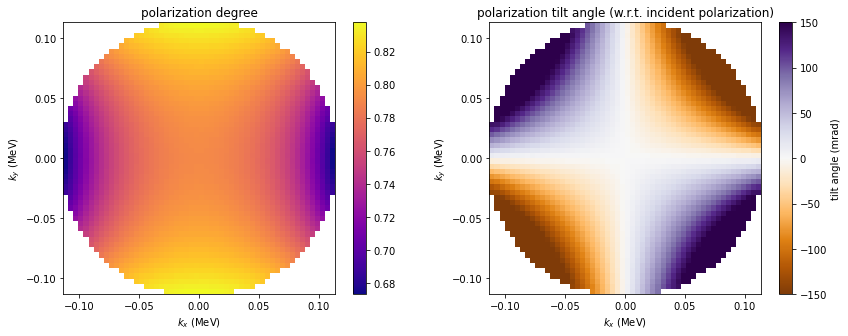

In [14]:
PolDegree = np.sqrt(Stokes1**2 + Stokes3**2 )

n         = K1 < 0

TiltAngle     = 0.5*np.arctan2(Stokes1,Stokes3) -  n *pi
TiltAngle_rot = 0.5*np.arctan2(Stokes_rot1,Stokes_rot3) #-  n *pi

phi =  arctan2(K2,K1)

# figure(figsize=(10,6))

bbins = (54,52)

# subplot(111,aspect=1)
values_w_s, xedge, yedge = histogram2d(K1/1e6,K2/1e6,bins=bbins,weights=W*PolDegree )
values_w  , xedge, yedge = histogram2d(K1/1e6,K2/1e6,bins=bbins,weights=W           )
values_w_tilt, xedge, yedge = histogram2d(K1/1e6,K2/1e6,bins=bbins,weights=W*TiltAngle_rot )
values_w_phi , xedge, yedge = histogram2d(K1/1e6,K2/1e6,bins=bbins,weights=W*phi )

# print (histogram2d(K1/1e6,K2/1e6,bins=(51,51),weights=W*PolDegree))

fig,ax = subplots(1,2,figsize=(14,5))
p=ax[0].pcolormesh( xedge, yedge, (values_w_s / values_w).T ,rasterized=True,cmap=cm.plasma);
colorbar(p,ax=ax[0])


tilt_angle_in_lab_rot = values_w_tilt / values_w

tilt_angle_in_lab = (values_w_tilt + values_w_phi) / values_w

renormalized_tilt_angle0  = nan_to_num(tilt_angle_in_lab )

renormalized_tilt_angle = (( renormalized_tilt_angle0 + pi )%(2*pi) -pi)

print (amax(renormalized_tilt_angle),amin(renormalized_tilt_angle))

# p=ax[1].pcolormesh( xedge, yedge, tilt_angle_in_lab_rot.T ,rasterized=True,cmap=cm.PuOr, vmin=-0.2,vmax=0.2);
p=ax[1].pcolormesh( xedge, yedge, 1000*tilt_angle_in_lab_rot.T ,rasterized=True,cmap=cm.PuOr, vmin=-150,vmax=150);
colorbar(p,ax=ax[1], label='tilt angle (mrad)')


for axj in ax:
    axj.set_aspect(1)
    axj.set_xlabel(r'$k_x$ (MeV)')
    axj.set_ylabel(r'$k_y$ (MeV)')

ax[0].set_title(r'polarization degree')
ax[1].set_title(r'polarization tilt angle (w.r.t. incident polarization)')

savefig(f'polarization_state_{input_filename}.pdf')


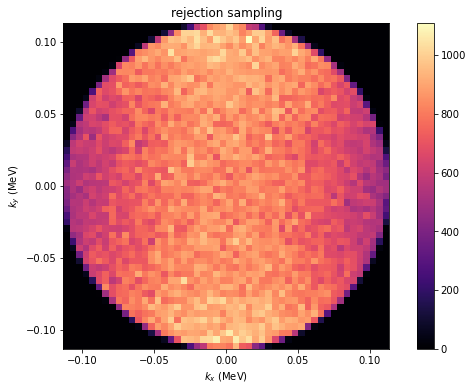

In [15]:
figure(figsize=(10,6))

subplot(111,aspect=1)
hist2d(K1/1e6,K2/1e6,bins=(50,50),weights=W,rasterized=True,cmap=cm.magma);
colorbar()
title(f'{sampling} sampling')

xlabel(r'$k_x$ (MeV)')
ylabel(r'$k_y$ (MeV)')


savefig(f'photon_transverse_momentum_{input_filename}.pdf')

KeyboardInterrupt: 

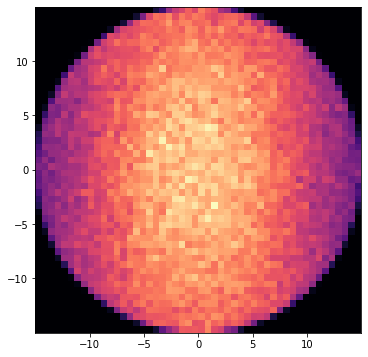

In [16]:
figure(figsize=(10,6))

subplot(111,aspect=1)
hist2d(K1/K3*1e6,K2/K3*1e6,bins=(50,50),weights=W,rasterized=True,cmap=cm.magma);
colorbar()
title(f'{sampling} sampling')

xlabel(r'$\theta_x$ (urad)')
ylabel(r'$\theta_y$ (urad)')


savefig(f'photon_transverse_angles_{input_filename}.pdf')

In [ ]:
figure(figsize=(10,6))

bbins=(linspace(-2*w0,2*w0,50),linspace(-2*w0,2*w0,50))

subplot(111,aspect=1)
hist2d(X1,X2,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$x@$source (micron)')
ylabel(r'$y@$source (micron)')
title(f'{sampling} sampling')

xlim(-2*w0,2*w0)
ylim(-2*w0,2*w0)


savefig(f'photon_source_size_{input_filename}.pdf')


In [ ]:
figure(figsize=(10,6))
bbins=(linspace(-75,75,50),linspace(-2*w0,2*w0,50))

subplot(111)
hist2d(X0-X3,X1,bins=bbins,weights=W ,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$t-z@$source (micron)')
ylabel(r'$x@$source (micron)')
title(f'{sampling} sampling')



savefig(f'photon_source_length_{input_filename}.pdf')


In [ ]:
figure(figsize=(10,6))
bbins=(50,50)

subplot(111)
hist2d(X0-X3,X0+X3,bins=bbins,weights=W ,rasterized=True,cmap=cm.magma);
colorbar()

xlabel(r'$t-z@$source (micron)')
ylabel(r'$t+z@$source (micron)')
title(f'{sampling} sampling')



savefig(f'photon_source_lightfront_{input_filename}.pdf')


In [ ]:
figure(figsize=(10,6))

bbins=(55,55)#(linspace(6,9,50),linspace(0,15,50))

subplot(111)
hist2d(K0/1e9,sqrt(K1**2+K2**2)/K3*1e6,bins=bbins,weights=W/sqrt(K1**2+K2**2),rasterized=True,cmap=cm.magma);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ ($\mu$rad)');
title(rf'{sampling} sampling')


savefig(f'photon_angular_spectrum_{input_filename}.pdf')


In [ ]:
figure(figsize=(10,6))

bbins=(linspace(6,9,50),linspace(0,50,50))

subplot(111)
hist2d(K0/1e9,sqrt(X1**2+X2**2),bins=bbins,weights=W/sqrt(X1**2+X2**2),rasterized=True,cmap=cm.magma);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$r$ ($\mu$m)');
title(rf'{sampling} sampling')
ylim(0,w0)

savefig(f'photon_transverse_spectrum_{input_filename}.pdf')


In [ ]:
thetax=K1/K3
thetay=K2/K3

baseline = 7.5e6 

xoffset = thetax * baseline
yoffset = thetay * baseline

In [ ]:
spotsize = 10 # micron


figure(figsize=(14,6))

ax1=subplot(121,aspect=1)
scatter(xoffset, yoffset, color='r',marker='.',lw=0,s=W);
xlim(-2*spotsize,2*spotsize)
ylim(-2*spotsize,2*spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('zero source size')


ax2=subplot(122,aspect=1)

# plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);
scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

xlim(-2*spotsize,2*spotsize)
ylim(-2*spotsize,2*spotsize)

xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('finite source size')

ax1.add_patch(Circle((0,0),spotsize,color='C0',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='C0',fill=False))


suptitle(f'{sampling} sampling')

savefig(f'photons_at_focus_{input_filename}.png',dpi=200)



In [ ]:
spotsize = 10 # micron


figure(figsize=(14,6))

ax1=subplot(121,aspect=1)
scatter(X1+xoffset, X2+yoffset, c=Stokes1, marker='s',lw=0,s=50,vmin=-1,vmax=1,cmap=cm.PuOr);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('Stokes 1')


ax2=subplot(122,aspect=1)

# plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);
scatter(X1+xoffset, X2+yoffset, c=Stokes3, marker='s',lw=0,s=50,vmin=-1,vmax=1,cmap=cm.PuOr);
colorbar()

xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)

xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('Stokes 3')

ax1.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))


suptitle(f'{sampling} sampling')

savefig(f'photons_at_focus_StokesParameters_{input_filename}.png',dpi=200)



In [ ]:
spotsize = 10 # micron

phi = arctan2(K2,K1)
# rotated Stokes parameters
Stokes_rot3 = cos(2*phi) * Stokes3 - sin(2*phi) * Stokes1
Stokes_rot1 = sin(2*phi) * Stokes3 + cos(2*phi) * Stokes1



figure(figsize=(18,4))

ax1=subplot(131,aspect=1)
scatter(X1+xoffset, X2+yoffset, c=sqrt(Stokes1**2 + Stokes3**2), marker='s',lw=0,s=20,cmap=cm.jet);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');
title('Polarization degree')


ax2=subplot(132,aspect=1)

title('Stokes parameter S1 in lab frame')

scatter(X1+xoffset, X2+yoffset, c=Stokes_rot1, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.jet);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');

ax3=subplot(133,aspect=1)

title('Stokes parameter S3 in lab frame')

scatter(X1+xoffset, X2+yoffset, c=Stokes_rot3, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.jet);
colorbar()
xlim(-spotsize,spotsize)
ylim(-spotsize,spotsize)
xlabel(r'$x$ (micron)')
ylabel(r'$y$ (micron)');

ax1.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))
ax2.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))
ax3.add_patch(Circle((0,0),spotsize,color='0.5',fill=False))


# suptitle(f'{sampling} sampling')

savefig(f'PolarizationDegree2_{input_filename}.png',dpi=200)



In [ ]:
spotsize = 10 # micron

phi = arctan2(K2,K1)
# rotated Stokes parameters
Stokes_rot3 = cos(2*phi) * Stokes3 - sin(2*phi) * Stokes1
Stokes_rot1 = sin(2*phi) * Stokes3 + cos(2*phi) * Stokes1



figure(figsize=(18,4))

ax1=subplot(131)
scatter(K0/1e9, 1e6* sqrt(K1**2+K2**2)/K3, c=sqrt(Stokes1**2 + Stokes3**2), marker='s',lw=0,s=20,cmap=cm.jet);
colorbar()
# xlim(-spotsize,spotsize)
# ylim(-spotsize,spotsize)
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('Polarization degree')


ax2=subplot(132)

title('Stokes parameter S1 in lab frame')

scatter(K0/1e9,  1e6*sqrt(K1**2+K2**2)/K3, c=Stokes_rot1, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
# xlim(-spotsize,spotsize)
# ylim(-spotsize,spotsize)
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('Stokes parameter S3 in lab frame')

scatter(K0/1e9,  1e6*sqrt(K1**2+K2**2)/K3, c=Stokes_rot3, marker='s',s=20,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
# xlim(-spotsize,spotsize)
# ylim(-spotsize,spotsize)
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'PolarizationDegree_energyangle_scatter_{input_filename}.png',dpi=200)



In [ ]:
spotsize = 10 # micron

phi = arctan2(K2,K1)
# rotated Stokes parameters
Stokes_rot3 = cos(2*phi) * Stokes3 - sin(2*phi) * Stokes1
Stokes_rot1 = sin(2*phi) * Stokes3 + cos(2*phi) * Stokes1
PolDegree   = np.sqrt(Stokes1**2 + Stokes3**2)

bbins = (54,52)

# subplot(111,aspect=1)
values_w_s, xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree )
values_w  , xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W           )
values_w_rot3, xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot3 )
values_w_rot1 , xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot1 )



figure(figsize=(18,4))

ax1=subplot(131)
pcolormesh(xedge, yedge , (values_w_s / values_w ).T , cmap=cm.jet, vmin=0,vmax=1);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('Polarization degree')


ax2=subplot(132)
title('Stokes parameter S1 in lab frame')

pcolormesh(xedge, yedge, (values_w_rot1/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('Stokes parameter S3 in lab frame')

pcolormesh(xedge, yedge, (values_w_rot3/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'PolarizationDegree_energyangle_histogram_{input_filename}.png',dpi=200)



In [ ]:
spotsize = 10 # micron

phi = arctan2(K2,K1)
# rotated Stokes parameters
Stokes_rot3 = cos(2*phi) * Stokes3 - sin(2*phi) * Stokes1
Stokes_rot1 = sin(2*phi) * Stokes3 + cos(2*phi) * Stokes1
PolDegree   = np.sqrt(Stokes1**2 + Stokes3**2)

bbins = (54,52)

# subplot(111,aspect=1)
values_w_s, xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree )
values_w  , xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W           )
values_w_rot3, xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot3 )
values_w_rot1 , xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot1 )



figure(figsize=(18,4))

ax1=subplot(131)
pcolormesh(xedge, yedge , (values_w_s / values_w ).T , cmap=cm.jet, vmin=0,vmax=1);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('Polarization degree')


ax2=subplot(132)
title('Stokes parameter S1 in lab frame')

pcolormesh(xedge, yedge, (values_w_rot1/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('Stokes parameter S3 in lab frame')

pcolormesh(xedge, yedge, (values_w_rot3/values_w).T, rasterized=True,vmin=-1,vmax=1,cmap=cm.PiYG);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'PolarizationDegree_energyangle2_{input_filename}.png',dpi=200)



In [ ]:
# standard deviations

spotsize = 10 # micron

phi = arctan2(K2,K1)
# rotated Stokes parameters
Stokes_rot3 = cos(2*phi) * Stokes3 - sin(2*phi) * Stokes1
Stokes_rot1 = sin(2*phi) * Stokes3 + cos(2*phi) * Stokes1
PolDegree   = np.sqrt(Stokes1**2 + Stokes3**2)

bbins = (54,52)

# subplot(111,aspect=1)
values_w_s, xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree )
values_w  , xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W           )
values_w_rot3, xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot3 )
values_w_rot1 , xedge, yedge = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot1 )

mean_poldegree = values_w_s/values_w
mean_rot1      = values_w_rot1/values_w
mean_rot3      = values_w_rot3/values_w

values_moment2_w_s, *_    = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*PolDegree**2 )
values_moment2_w_rot1, *_ = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot1**2 )
values_moment2_w_rot3, *_ = histogram2d(K0/1e9,1e6* np.sqrt(K1**2+K2**2)/K3,bins=bbins,weights=W*Stokes_rot3**2 )

var_s    = values_moment2_w_s    / values_w - mean_poldegree**2
var_rot1 = values_moment2_w_rot1 / values_w - mean_rot1**2
var_rot3 = values_moment2_w_rot3 / values_w - mean_rot3**2

std_s       = sqrt(var_s)
std_rot1    = sqrt(var_rot1)
std_rot3    = sqrt(var_rot3)


figure(figsize=(18,4))

ax1=subplot(131)
pcolormesh(xedge, yedge , std_s.T , cmap=cm.pink_r);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');
title('STD Polarization degree')


ax2=subplot(132)
title('STD Stokes parameter S1 in lab frame')

pcolormesh(xedge, yedge, std_rot1.T, rasterized=True,cmap=cm.pink_r);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');


ax3=subplot(133)

title('STD Stokes parameter S3 in lab frame')

pcolormesh(xedge, yedge, std_rot3.T, rasterized=True,cmap=cm.pink_r);
colorbar()
xlabel(r'$\omega$ (GeV)')
ylabel(r'$\theta$ (urad)');




# suptitle(f'{sampling} sampling')

savefig(f'PolarizationDegree_STD_{input_filename}.png',dpi=200)



In [ ]:
selector1 = sqrt(xoffset**2+yoffset**2) < spotsize
selector2 = sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize


print ( f'IP-laser spot size: {spotsize:.2f} micron')
print ( f'baseline          : {baseline/1e6:.2f} metres')
print ('-'*42)

print (f'photons in spot, {sampling} sampling:')
print (f'macrophoton weight               : {amax(W):.4g}')
print ( 'macrophotons, zero   source size :',sum( selector1 ) )
print ( 'macrophotons, finite source size :',sum( selector2 ) )
print ( 'photon weight, zero   source size:',sum(W[selector1 ] ) )
print ( 'photon weight, finite source size:',sum(W[selector2 ] ) )


### Photon Spectrum at IP

In [ ]:
figure(figsize=(10,6))

subplot(111)
hist(K0[selector1]/1e9,bins=linspace(6,9,50),weights=W[selector1],alpha=1  ,fc='C0',label='no source size');
hist(K0[selector2]/1e9,bins=linspace(6,9,50),weights=W[selector2],alpha=0.5,fc='C3',label='finite source size'); 
xlim(6,9)
legend()
xlabel('ICS photon energy (GeV)')
ylabel('photon spectrum at IP')
title(rf'{sampling} sampling')

savefig(f'photon_spectrum_at_focus_{input_filename}.pdf')


### Photon Weight Distribution at IP

In [ ]:
figure(figsize=(10,6))
base_weight = amax(W)
bbins = linspace(0,base_weight,50) 

hist( W[selector1],bins=bbins,label='zero source size'  ,fc='C0');
hist( W[selector2],bins=bbins,label='finite source size',fc='C3',alpha=0.5);


xlabel('macrophoton weigths')
ylabel('#macrophotons with weight')
title(rf'{sampling} sampling')
legend()
savefig(f'photon_weights_{input_filename}.pdf')


In [ ]:
figure(figsize=(10,6))
base_weight = amax(W)
bbins = linspace(0,base_weight,50) 

hist( W[selector1],bins=bbins,weights=W[selector1],label='zero source size'  ,fc='C0',alpha=1.0);
hist( W[selector2],bins=bbins,weights=W[selector2],label='finite source size',fc='C3',alpha=0.5);

xlabel('macrophoton weigths')
ylabel('#macrophotons with weight')
title(rf'{sampling} sampling')
legend()
savefig(f'photon_weights2_{input_filename}.pdf')


# Electrons

In [ ]:
fig,ax=subplots(1,3,figsize=(20,6))
bbins=(50,50)

p0=ax[0].hist2d(P3/1e9,P1/1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p0,ax=ax[0])

p1=ax[1].hist2d(P3/1e9,P2/1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p1,ax=ax[1])

p2=ax[2].hist2d(P1/1e6,P2/1e6,bins=bbins,weights=W,rasterized=True,cmap=cm.magma);
# colorbar(p2,ax=ax[2])


ax[0].set_xlabel(r'electron $p_z$ (GeV)')
ax[1].set_xlabel(r'electron $p_z$ (GeV)')
ax[2].set_xlabel(r'electron $p_x$ (MeV)')

ax[0].set_ylabel(r'electron $p_x$ (MeV)')
ax[1].set_ylabel(r'electron $p_y$ (MeV)')
ax[2].set_ylabel(r'electron $p_y$ (MeV)')


savefig(f'electrons_final_momentum_{input_filename}.pdf')


In [ ]:
theta_ex = P1/P3
theta_ey = P2/P3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

bbins=(linspace(7.5,11.5,50),linspace(0,50,50))

fig,ax=subplots(1,1,figsize=(10,6))

hist2d( P0/1e9 , theta_e*1e6 , bins=bbins , weights=W/theta_e );

xlabel(r'electron energy $E$ (GeV)')
ylabel(r'electron angle $\theta$ ($\mu$rad)');

savefig(f'electrons_final_energy_angle_{input_filename}.pdf')


In [ ]:
fig,ax=subplots(1,1,figsize=(10,6))
bbins=(50,50)

p0=ax.hist(P3/1e9,bins=70,weights=W);
p0=ax.hist(P0/1e9,bins=70,weights=W,alpha=0.5);
xlabel(r'electron energy $E$ (GeV)')

savefig(f'electrons_final_energy_{input_filename}.pdf')


In [ ]:
theta_ex = P1/P3
theta_ey = P2/P3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

bbins=(linspace(16.4,16.6,50),linspace(-0.5,0.5,50))

fig,ax=subplots(1,1,figsize=(10,6))

hist2d( (P3+K3)/1e9 , (P1+K1)/1e6 , bins=bbins );
xlabel(r'initial electron beam $p_z$')
ylabel(r'initial electron beam $p_x$')




In [ ]:
theta_x = K1/K3
theta_y = K2/K3
theta_e  = sqrt(theta_ex**2+theta_ey**2)

bbins=(100,100)#(linspace(16.4,16.6,50),linspace(-0.5,0.5,50))

fig,ax=subplots(1,1,figsize=(10,6))

hist2d( theta_x , theta_y , bins=bbins );



In [ ]:
omega0 = 4.1
gamma0 = 32289.62818003914

omega = 2*gamma0*omega0
elec_mass = 511000.


omega1 = omega/(1+2*omega/elec_mass)